<a href="https://colab.research.google.com/github/faikozcan/MLFraud/blob/main/Wide_DeepWithCustomModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Dataset

In [4]:
#https://medium.com/ml-book/train-tf-keras-model-using-feature-coulmn-8de12e65ddec
import numpy as np
import pandas as pd
import requests 
import io
from tensorflow import feature_column as fc
import tensorflow as tf
from sklearn.model_selection import train_test_split

def get_scal(feature):
  def minmax(x):
    mini = train[feature].min()
    maxi = train[feature].max()
    return (x - mini)/(maxi-mini)
  return(minmax)
url="https://raw.githubusercontent.com/faikozcan/MLFraud/main/dataFiles/Fraud_DataWithCountry.csv"
s=requests.get(url).content



#,usecols=["user_id","signup_time","purchase_time","purchase_value","device_id","source","browser","sex","age","ip_address","ip_country","class"]
df=pd.read_csv(io.StringIO(s.decode('utf-8')),sep = ",",usecols=['purchase_value','user_id','device_id','ip_country','age','sex','source','browser','class'])
df.head(10)
df.astype(object).describe()

,user_id,purchase_value,device_id,source,browser,sex,age,class,ip_country
count,151112,151112,151112,151112,151112,151112,151112,151112,151112
unique,151112,122,137956,3,5,2,58,2,182
top,381673,28,EQYVNEGOFLAWK,SEO,Chrome,M,32,0,United States
freq,1,3328,20,60615,61432,88293,6666,136961,58049


Balancing Dataset With Oversampling

Examples:
    Total: 151112
    Positive: 14151 (9.36% of total)

Class 0: 136961
Class 1: 14151
Proportion: 9.68 : 1
Random over-sampling:
1    136961
0    136961
Name: class, dtype: int64


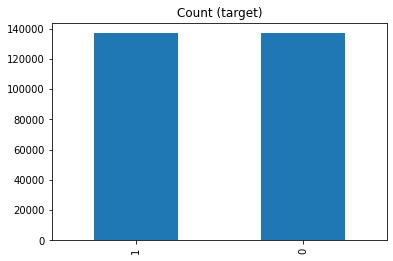

In [5]:
neg, pos = np.bincount(df['class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

target_count = df['class'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')


# Class count
count_class_0, count_class_1 = df['class'].value_counts()

# Random Over Sampling 
df_class_0 = df[df['class'] == 0]
df_class_1 = df[df['class'] == 1]

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
dfOverSampled = pd.concat([df_class_0, df_class_1_over], axis=0)
print('Random over-sampling:')
targetCountsOverSampled=dfOverSampled['class'].value_counts()
print(targetCountsOverSampled)
targetCountsOverSampled.plot(kind='bar', title='Count (target)');

Split Training And Test Data

In [7]:
#split %20 of data for test, %80 of data for training
train, test = train_test_split(dfOverSampled, test_size=0.20)

#split training data, seperate %10 of training data for validation
train, val = train_test_split(train, test_size=0.10)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

197223 train examples
21914 validation examples
54785 test examples


In [8]:
deep_columns=[]
wide_columns = []
categorical_columns = {}

#numerical features
num_c = ['purchase_value']
#bucketized numerical features
bucket_c =['age'] 
#categorical features
cat_i_c =['sex','source','browser','ip_country'] #indicator columns
cat_e_c =['device_id','user_id'] # embedding column


for header in num_c:
  scal_input_fn = get_scal(header)
  deep_columns.append(fc.numeric_column(header, normalizer_fn=scal_input_fn))
  
  

age = fc.numeric_column('age')

# bucketized cols
age_buckets = fc.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
deep_columns.append(age_buckets)

#embedding columns
for feature_name in cat_e_c:
  vocabulary = df[feature_name].unique()
  cat_c = fc.categorical_column_with_vocabulary_list(feature_name, vocabulary)
  embeding = fc.embedding_column(cat_c, dimension=3)
  deep_columns.append(embeding)

#indicator columns
for feature_name in cat_i_c:
  vocabulary = df[feature_name].unique()
  cat_c = fc.categorical_column_with_vocabulary_list(feature_name, vocabulary)
  categorical_columns[feature_name]=cat_c
  one_hot = fc.indicator_column(cat_c)
  deep_columns.append(one_hot)

#crossed columns
vocabularyGender = df['sex'].unique()
gender =fc.categorical_column_with_vocabulary_list('sex', vocabularyGender) 
crossed_feature = fc.crossed_column([age_buckets, gender], hash_bucket_size=18)
crossed_feature = fc.indicator_column(crossed_feature)
wide_columns.append(crossed_feature)

# userid_X_source = fc.crossed_column(['user_id', 'source'], hash_bucket_size=400000)
# crossed_feature1 = fc.indicator_column(userid_X_source)
# wide_columns.append(crossed_feature1)

# deviceId_X_browser = fc.crossed_column(['device_id', 'browser'], hash_bucket_size=600000)
# crossed_feature2 = fc.indicator_column(deviceId_X_browser)
# wide_columns.append(crossed_feature2)


inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') \
          for colname in ['purchase_value','age']
}
inputs.update ({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='int64') \
          for colname in ['user_id']
})
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string') \
          for colname in ['browser','source','sex','device_id','ip_country']
})
# To apply L1 and L2 regularization, you can set dnn_optimizer to:
custom_Optimizer=  tf.keras.optimizers.Adam(
    learning_rate=0.01)

def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns)(inputs)
    for numnodes in dnn_hidden_units:
        deep = tf.keras.layers.Dense(numnodes, activation='relu')(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns)(inputs)
    both = tf.keras.layers.concatenate([deep, wide])
    output = tf.keras.layers.Dense(1, activation='sigmoid')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer=custom_Optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
model = wide_and_deep_classifier(inputs, wide_columns, deep_columns, [64, 16])





# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('class')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds



batch_size = 32
train_ds = df_to_dataset(train,shuffle=True, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)



callbacks = [
    tf.keras.callbacks.TensorBoard(
        log_dir='logs'
    )
]
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=5,
          verbose=1,
          callbacks=callbacks)
model.summary()
model.evaluate(test_ds,steps=100)






Epoch 1/5
6164/6164 [==============================] - 75s 12ms/step - loss: 0.4424 - accuracy: 0.7605 - val_loss: 0.0529 - val_accuracy: 0.9849
Epoch 2/5
6164/6164 [==============================] - 72s 12ms/step - loss: 0.0127 - accuracy: 0.9961 - val_loss: 0.0325 - val_accuracy: 0.9917
Epoch 3/5
6164/6164 [==============================] - 73s 12ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0217 - val_accuracy: 0.9957
Epoch 4/5
6164/6164 [==============================] - 73s 12ms/step - loss: 1.1188e-04 - accuracy: 1.0000 - val_loss: 0.0842 - val_accuracy: 0.9923
Epoch 5/5
6164/6164 [==============================] - 73s 12ms/step - loss: 5.2950e-04 - accuracy: 1.0000 - val_loss: 0.1219 - val_accuracy: 0.9903
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
age (InputLayer)                [(None,)]            0

[0.10722137242555618, 0.9906250238418579]